Лабораторная №4.

Загружаем библиотеки

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math


Загружаем изображение и прописываем функцию сравнения двух изображений

In [4]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

def image_diff(image1, title1, image2, title2):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(image1, cmap='gray')
    plt.title(title1)

    plt.subplot(1,2,2)
    plt.imshow(image2, cmap='gray')
    plt.title(title2)

    plt.show()

Алгоритм разрастания регионов. Критерий однородности - average

In [5]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255

Зададим координаты газона через seed_point.

In [6]:
seed_point = (250,150)

Используем алгоритм разрастания регионов с коэффициентами (2,18)

13
34
51
69
75
84
94
99
98
92
95
111
116
119
141
139
142
171
145
151
172
146
151
100
60
56
60
60
56
54
56
58
57
55
57
55
57
98
51
57
55
56
55
58
56
52
53
50
53
52
50
48
49
52
51
55
53
55
54
51
52
50
46
50
51
53
49
47
51
48
50
52
51
52
48
49
51
49
48
50
48
50
48
46
47
47
46
45
47
48
49
49
48
45
45
45
45
43
43
43
42
40
40
35
37
37
39
38
35
34
31
25
23
23
19
14
12
7
4
0


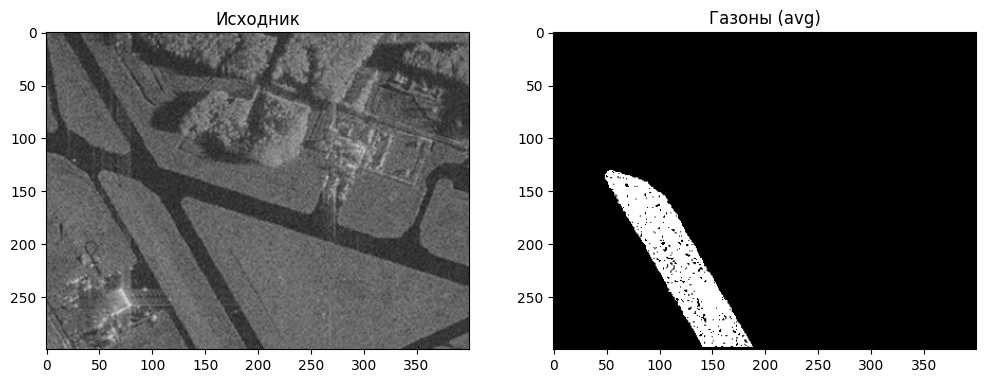

In [7]:
mask_avg = region_growing(image_gray,seed_point,homo_average,2, 18)

image_diff(image, 'Исходник', mask_avg, 'Газоны (avg)')

Используем другой критерий однородности (медианный)

In [8]:
def homo_median(image, mask, point, T):
    if np.count_nonzero(mask > 0) == 0:
        return False
    
    median_val = np.median(image[mask > 0])
    
    if abs(median_val - image[point]) <= T:
        return True
    
    return False

Используем этот критерий в нашем алгоритме разрастания регионов

13
34
51
69
76
84
94
99
99
95
98
103
116
128
132
151
145
156
168
153
147
147
152
130
60
58
60
62
59
56
58
58
58
57
58
56
58
93
53
57
57
57
57
57
54
52
53
53
53
52
52
49
51
54
53
56
53
55
54
51
52
50
47
51
51
53
50
51
52
48
53
52
51
50
49
48
51
49
47
49
49
47
48
46
48
45
46
47
47
47
49
49
48
45
45
45
44
43
43
42
42
39
41
36
36
35
38
38
35
34
31
25
24
23
19
14
13
7
4
0


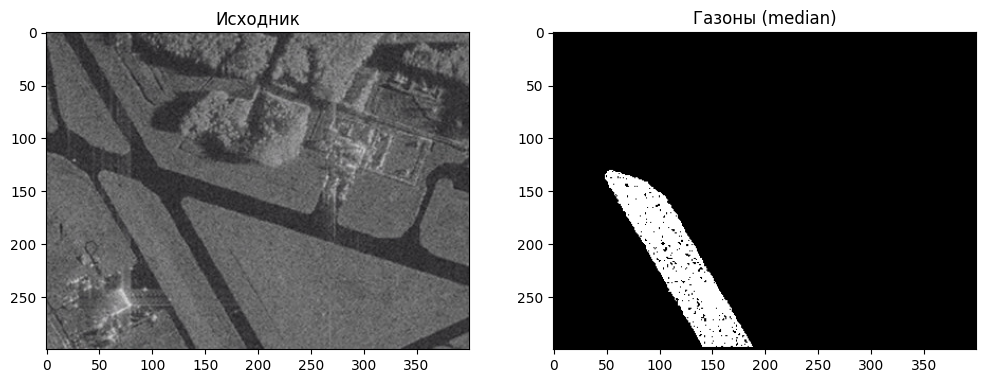

In [9]:
mask_median = region_growing(image_gray,seed_point,homo_median,2, 18)

image_diff(image, 'Исходник', mask_median, 'Газоны (median)')

Сравним результаты, полученные при разных критериях

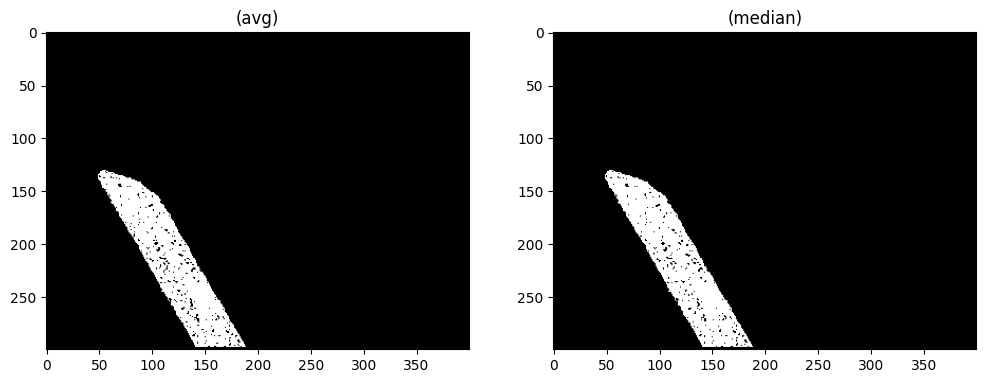

average / img: SSIM = 0.0104; MSE = 9713.8051
median / img: SSIM = 0.0113; MSE = 9715.3330


In [10]:
from skimage.metrics import structural_similarity, mean_squared_error

(ssim_average, diff_average) = structural_similarity(image_gray, mask_avg, full=True)
(ssim_median, diff_median) = structural_similarity(image_gray, mask_median, full=True)

mse_average = mean_squared_error(image_gray, mask_avg)
mse_median = mean_squared_error(image_gray, mask_median)

diff_average = (diff_average * 255).astype("uint8")
diff_median = (diff_median * 255).astype("uint8")

image_diff(mask_avg, '(avg)',mask_median, '(median)')
print(f"average / img: SSIM = {ssim_average:.4f}; MSE = {mse_average:.4f}")
print(f"median / img: SSIM = {ssim_median:.4f}; MSE = {mse_median:.4f}")

Загрузим изображение пальм.

In [11]:
image = cv2.imread('palm_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

Применим алгоритм сегментации watershed+distance transform для того, чтобы посчитать кол-во пальм на картинке

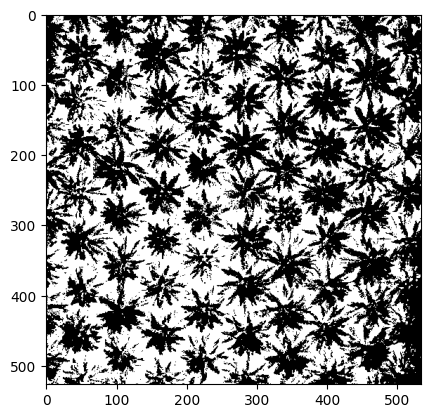

In [12]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

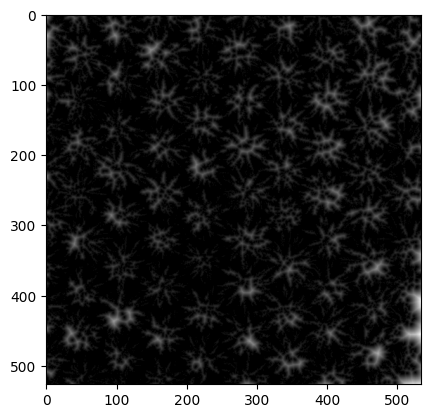

In [13]:
thresh = 255 - thresh
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

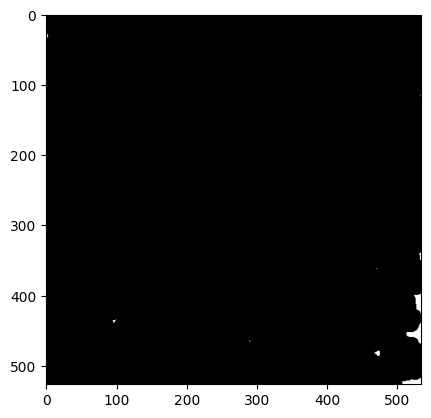

In [ ]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

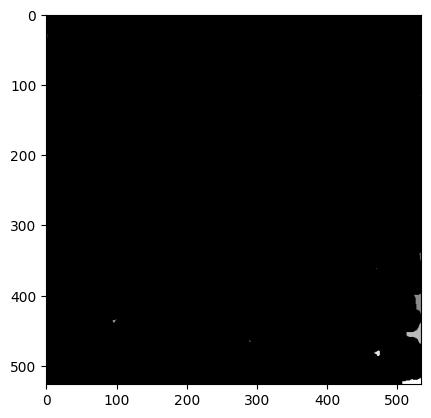

In [15]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg) 
plt.imshow(markers, cmap="gray")

Выведем результат

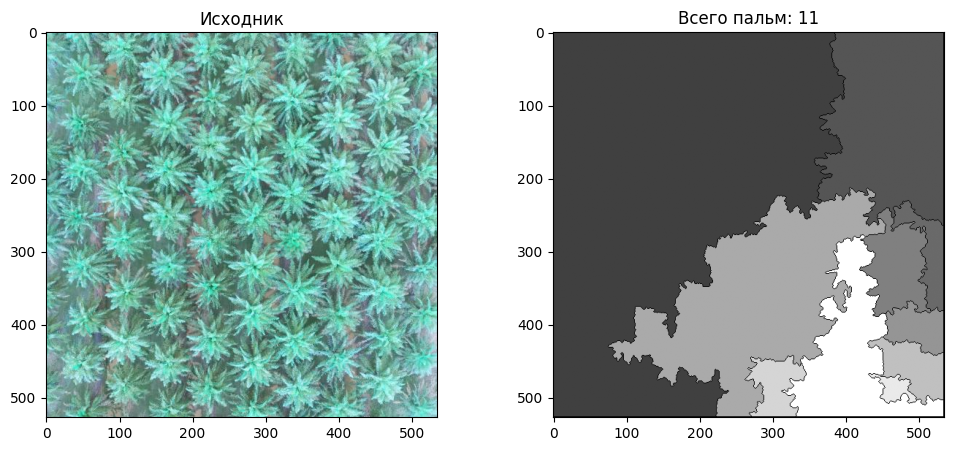

In [16]:
markers = cv2.watershed(image, markers)
image_diff(image, 'Исходник', markers, "Всего пальм: "+str(len(np.unique(markers))))
